# Introduction

On Twitter today Jonathan McDowell made the following comment (https://twitter.com/planet4589/status/879927853332213760):

>Russian cubesat 'Mayak' to launch Jul 14 will deploy a reflector that may be as bright as mag minus 10. Astronomers likely to be annoyed.

This resulted in comprehensive nerd sniping (https://xkcd.com/356/) of both myself (https://twitter.com/vacant3rdman/status/879937146508812289) and Matthew Kenworthy (https://twitter.com/mattkenworthy/status/879954847809888256), and possibly others. As a result I was compelled to attempt to work out the maximum apparent brightness of mirrored surfaces in Earth orbit. This notebook is the result.

# Brightness of an orbital mirror

The apparent brightness of a specular reflection of sunlight off a flat surface is simply given by the apparent brightness of the Sun scaled by the ratio of the solid angles subtended by the reflector and the Sun from the observer's position and by the specular reflectance of the surface (which will, in general, be a function of wavlength and angle of incidence). Expressed in astronomical magnitudes (yuck), this becomes

$m_\textrm{sat} = m_{\odot} - 2.5 \times \log_{10}\left(\frac{\Omega_\textrm{sat}}{\Omega_\odot}.R_\textrm{sat}\right)$,

where $m_\textrm{sat}$ and $m_\odot$ are the apparent magnitudes of the satellite and Sun respectively, $\Omega_\textrm{sat}$ and $\Omega_\odot$ are their solid angles and $R_\textrm{sat}$ is the reflectance of the flat surface on the satellite.

For a flat surface of area $A$ at an angle $\theta$ to the line of sight and seen from a distance $d$ the solid angle (using small angle approximations) is given by

$\Omega_\textrm{sat} = \frac{A \cos{\theta}}{d^2}$

## Conversative upper limit for the Mayak CubeSat

We can put an upper limit on the apparent brightness of the satellite by using the minimum distance between observer and satellite (the altitude of the satellite's orbit, $a$) and normal incidence ($\theta=0$) so that we obtain

$m_\textrm{sat} > m_{\odot} - 2.5 \times \log_{10}\left(\frac{A.R_\textrm{sat}}{a^2 \Omega_\odot}\right)$.

Substituting in values for Mayak (http://space.skyrocket.de/doc_sdat/mayak.htm) of $A = 4\textrm{m}^2$, $a = 500\textrm{km}$ and $R_\textrm{sat} = 0.95$ we obtain the following limit

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import astropy.units as u
import astropy.constants as c
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [3]:
omega_sun = (np.pi * (c.R_sun / c.au)**2).to(u.sr, equivalencies=u.equivalencies.dimensionless_angles())
omega_sun

<Quantity 6.790524307451637e-05 sr>

In [4]:
m_sun = -26.74 * u.dimensionless_unscaled
m_sun

<Quantity -26.74>

In [5]:
area = 4 * u.m**2
altitude = 500 * u.km
reflectance = 0.95 * u.dimensionless_unscaled

In [6]:
omega_sat_max = (area / altitude**2).to(u.sr, equivalencies=u.equivalencies.dimensionless_angles())
omega_sat_max

<Quantity 1.6e-11 sr>

In [7]:
m_sat_min = m_sun - 2.5 * np.log10(omega_sat_max * reflectance / omega_sun)
m_sat_min

<Quantity -10.114850699461797>

**So we find that the apparent brightness of Mayak should be no brighter than -10.1 magnitudes, which is consistent with the -10 figure quoted on Gunter's Space page.**  It is also in agreement with the result that Matthew Kenworthy arrived at independently, https://twitter.com/mattkenworthy/status/879954847809888256

This is a conservative upper limit, however. For the satellite to be at a distance equal to the altitude of its orbit it must be directly overhead of the observer, and $\theta=0$ implies that the reflector surface is directly facing the observer. For a specular reflection of sunlight to reach the observer the angle of incidence must equal the angle of reflection, i.e. in this case the Sun must be in line with the satellite and observer, in other words on the opposite side of the Earth. The transmission of the entire planet at visible wavelengths is *extremely* low so in practice very little light would reach the satellite in this geometry.

## Slightly more rigourous limit

In reality the maximum brighness will occur when the observer, satellite and Sun lie in the same plane with the Sun some distance below the horizon from the observer's point of view but above the horizon from the satellite's point of view. The geometry is illustrated in this lovingly hand crafted diagram:

![Hand crafted diagram](https://photos.smugmug.com/Other/Stuff/i-Jk4FrC5/0/fab1dcbd/L/IMG20170628221654-L.jpg "Hand crafted diagram")

This introduces two new variables, the angular distance of the Sun below the horizon at the observer's position, $\phi$, and the zenith angle of the satellite from the observer's position. We must solve for the line of sight distance between the observer and satellite, $d$, and the angle of incidence and reflection at the mirror surface, $\theta$ in terms of these two variables. It was at this point that I realised that I had forgotten almost everything that I ever knew about elementary geometry and trigonometry. Fortunately Wikipedia came to the rescue.

### Angle of incidence/reflection

From the sum of the interior angles of a triangle, $\theta = \frac{\pi/2 - z - \phi}{2}$

### Line of sight distance

This an instance of the two side and non-included angle triangle problem (https://en.wikipedia.org/wiki/Solution_of_triangles#Two_sides_and_non-included_angle_given_.28SSA.29). The solution for the length of the third side gives

$d = R_\oplus \cos(\pi - z) \pm  \sqrt{(R_\oplus + a)^2 - R_\oplus \sin^2(\pi - z)}$

After a bit of arguably useful rearrangement this becomes

$d = a \left[ \sqrt{1 + \frac{2 R_\oplus}{a} + \frac{R_\oplus^2}{a^2}\cos^2 z} - \frac{R_\oplus}{a} \cos{z} \right]$,

which reassuringly gives $d = a$ when zenith angle is zero. Now we create a function to calculate $d$ as a function of $a$ and $z$ and plot the results.

In [8]:
def distance(altitude, zenith_angle):
    s = 1 + 2 * c.R_earth / altitude + (c.R_earth * np.cos(zenith_angle) / altitude)**2
    return (altitude * (s**0.5 - c.R_earth * np.cos(zenith_angle) / altitude)).to(u.km)

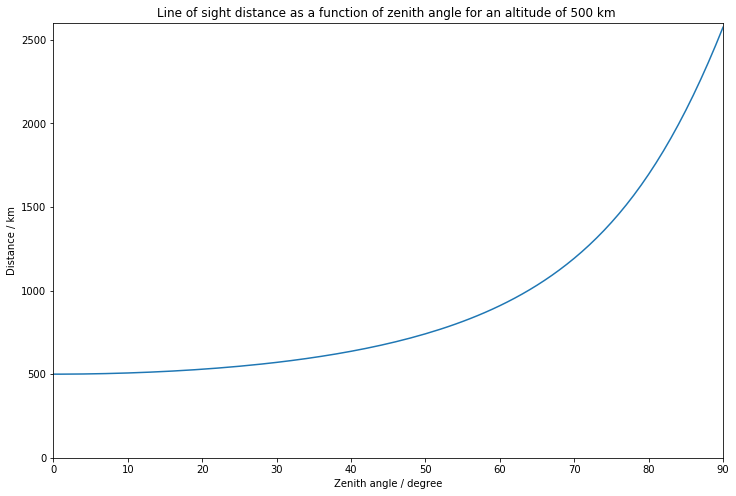

In [9]:
angles = np.arange(-90, 91, 1) * u.degree
plt.plot(angles, distance(altitude, angles))
plt.xlim(0, 90)
plt.ylim(0, 2600)
plt.xlabel('Zenith angle / degree')
plt.ylabel('Distance / km')
plt.title('Line of sight distance as a function of zenith angle for an altitude of 500 km ')
plt.gcf().set_size_inches(12, 8)

### Eclipse condition

In order for sunlight to be reflected from the satellite to the observer it is necessary that the Earth is not in the way, i.e. the spacecraft is not in eclipse. Calculating this condition in terms of satellite altitude, zenith angle and observer's Sun elevation required doing some more geometry. The solution is

$(R_\oplus + a) .\cos(\psi - \phi) > R_\oplus$,

where

$\psi = \arcsin\left(\frac{d \sin z}{R_\oplus + a}\right)$

We will write a function to determine whether the satellite is eclipsed

In [10]:
def is_eclipsed(altitude, zenith_angle, sun_elevation):
    los_distance = distance(altitude, zenith_angle)
    psi = np.arcsin(los_distance * np.sin(zenith_angle) / (c.R_earth + altitude))
    return (c.R_earth + altitude) * np.cos(psi - sun_elevation) < c.R_earth

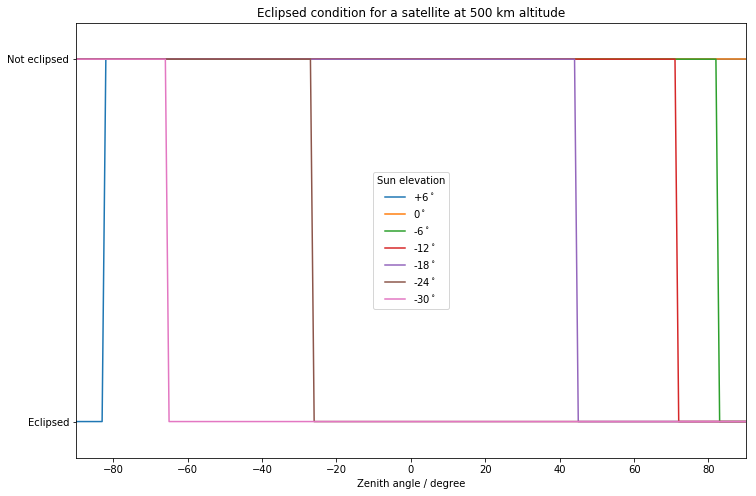

In [19]:
plt.plot(angles, is_eclipsed(altitude, angles, +6* u.degree), label='+6$^\circ$')
plt.plot(angles, is_eclipsed(altitude, angles, 0 * u.degree), label='0$^\circ$')
plt.plot(angles, is_eclipsed(altitude, angles, -6 * u.degree), label='-6$^\circ$')
plt.plot(angles, is_eclipsed(altitude, angles, -12 * u.degree), label='-12$^\circ$')
plt.plot(angles, is_eclipsed(altitude, angles, -18 * u.degree), label='-18$^\circ$')
plt.plot(angles, is_eclipsed(altitude, angles, -24 * u.degree), label='-24$^\circ$')
plt.plot(angles, is_eclipsed(altitude, angles, -30 * u.degree), label='-30$^\circ$')
plt.xlim(-90, 90)
plt.ylim(1.1,-0.1)
plt.xlabel('Zenith angle / degree')
plt.yticks((0, 1), ('Not eclipsed', 'Eclipsed'))
plt.title('Eclipsed condition for a satellite at 500 km altitude')
plt.legend(title='Sun elevation')
plt.gcf().set_size_inches(12, 8)

The perhaps surprising 'eclipsed' results for positive Sun elevation angles are indicating the situation when the satellite is in daylight but the Sun is on the opposite side of the mirror surface to the observer.

### Maximum brightness as a function of zenith angle and Sun elevation

Now we can write a function to calculate the maximum apparent brightness as a function of zenith angle and Sun elevation.

In [12]:
omega_sun = (np.pi * (c.R_sun / c.au)**2).to(u.sr, equivalencies=u.equivalencies.dimensionless_angles())
m_sun = -26.74 * u.dimensionless_unscaled

def m_sat(area, reflectance, altitude, zenith_angle, sun_elevation):
    angle_of_incidence = (np.pi * u.radian / 2 - zenith_angle + sun_elevation) / 2 # Elevation negative in twilight
    los_distance = distance(altitude, zenith_angle)
    omega_sat = (area * np.cos(angle_of_incidence) / \
                 los_distance**2).to(u.sr, equivalencies=u.equivalencies.dimensionless_angles())

    m_sat = np.where(is_eclipsed(altitude, zenith_angle, sun_elevation),
                     999 * u.dimensionless_unscaled,
                     m_sun - 2.5 * np.log10(omega_sat * reflectance / omega_sun)) * u.dimensionless_unscaled
    
    return m_sat

/mnt/data/ajh/Documents/virtualenvs/python3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log10
  # This is added back by InteractiveShellApp.init_path()


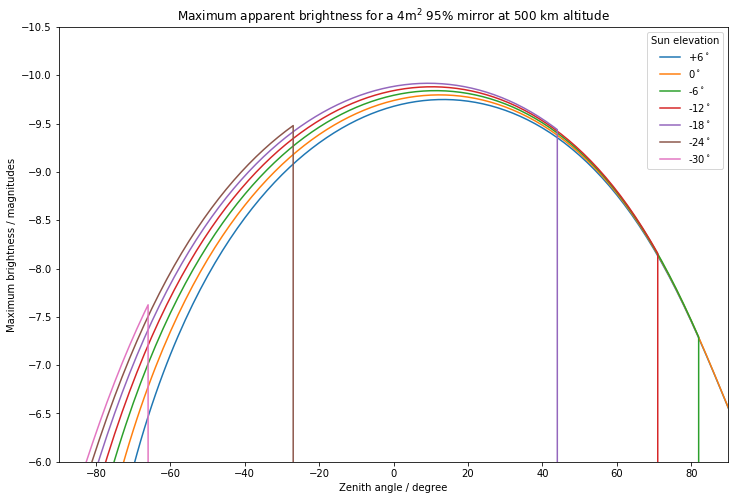

In [13]:
plt.plot(angles, m_sat(area, reflectance, altitude, angles, 6* u.degree), label='+6$^\circ$')
plt.plot(angles, m_sat(area, reflectance, altitude, angles, 0 * u.degree), label='0$^\circ$')
plt.plot(angles, m_sat(area, reflectance, altitude, angles, -6 * u.degree), label='-6$^\circ$')
plt.plot(angles, m_sat(area, reflectance, altitude, angles, -12 * u.degree), label='-12$^\circ$')
plt.plot(angles, m_sat(area, reflectance, altitude, angles, -18 * u.degree), label='-18$^\circ$')
plt.plot(angles, m_sat(area, reflectance, altitude, angles, -24 * u.degree), label='-24$^\circ$')
plt.plot(angles, m_sat(area, reflectance, altitude, angles, -30 * u.degree), label='-30$^\circ$')
plt.xlim(-90, 90)
plt.ylim(-6,-10.5)
plt.xlabel('Zenith angle / degree')
plt.ylabel('Maximum brightness / magnitudes')
plt.title('Maximum apparent brightness for a 4m$^2$ 95% mirror at 500 km altitude')
plt.legend(title='Sun elevation')
plt.gcf().set_size_inches(12, 8)
plt.savefig('mayak.png')

### Final result

We can maximise brightness (minimise magnitude) over zenith angle and Sun elevation to find the highest possible apparent brightness.

In [39]:
results = minimize(lambda x: m_sat(area, reflectance, altitude, x[0] * u.degree, x[1] * u.degree),
                   (0, -18),
                   method='Powell')
results

   direc: array([[ 1.,  0.],
       [ 0.,  1.]])
     fun: <Quantity -9.93558237180596>
 message: 'Optimization terminated successfully.'
    nfev: 56
     nit: 2
  status: 0
 success: True
       x: <Quantity [  8.84357143,-21.33344709]>

**So the maximum apparently brightness is, apparently, magnitude -9.9, which can occur when the Sun elevation is -21.3$^\circ$ and the satellite is at a zenith angle of 8.8$^\circ$ towards the antisolar direction**

In [75]:
m_sat_peak = results['fun']
mag_diff = m_sat_peak - m_sat_min
mag_diff

<Quantity 0.1792683276558371>

In [76]:
flux_ratio = 10**(-0.4 * mag_diff)
flux_ratio

<Quantity 0.8477985489924567>

In [77]:
inverse_flux_ratio = 10**(0.4 * mag_diff)
inverse_flux_ratio

<Quantity 1.1795254912719808>

This value is only 0.2 magnitudes fainter than the conservative (and far simpler) upper limit above, which is equivalent to 85% of the flux. I appear to have wasted a *lot* of time for a 18% improvement in accuracy...

# Flash duration

The entry for Mayak on Gunter's Space Page notes the following

>The reflector will provide a -10 optical magnitude at the beginning of the flight to allow for easy tracking. Mayak will be put into a tumbling motion over all axes, with at least 1 revolution per second

This suggests that Mayak may initially be in a stable orientation, resulting in flares of comparable duration to those from Iridium satellite (i.e. a few seconds) along a narrow ground track, but will spend most if not all of its mission in a rapid tumble. This will result in bright but very brief flashes of light visible over many different ground tracks as beams of reflected light sweep rapidly over the ground below.

## Maximum duration

During a flash the observer is effectively looking at a small portion of the Sun reflected in the mirrored surface of the satellite. The direction of the observer's reflected view will move across the sky at twice the angular rotation rate of the mirror, therefore the maximum flash duration will be time it takes for the satellite to rotate by half the angular diameter of the Sun.

In [54]:
omega_min = 2 * np.pi * u.radian / u.second
omega_min

<Quantity 6.283185307179586 rad / s>

In [55]:
duration_max = (c.R_sun / c.au).to(u.radian, equivalencies=u.equivalencies.dimensionless_angles()) / omega_min
duration_max

<Quantity 0.0007399405863332114 s>

**The maximum flash duration is therefore just over 0.7 milliseconds**. This is so short that it is likely to significantly reduce the perceived brightness as seen by the human eye. 

## Perceived brightness of short pulses

Bloch's Law states that below a certain threshold perceived brightness scales with total pulse energy rather than flux so that a pulse of half the length needs to be twice as bright in order to be perceived as the same brightness, however the situation is complicated by an apparent peak in sensitivity for pulse durations of ~50 milliseconds (Broca-Sulzer effect), see for example http://www.pnas.org/content/109/48/19828. If we assume that the Bloch's Law scaling holds for durations of ~40 milliseconds and shorter then the 0.7 millisecond maximum duration of the Mayak flashes could mean that they appear a lot fainter than -9.9 magnitudes.

In [72]:
perception_factor = (duration_max / (40 * u.ms)).to(u.dimensionless_unscaled)
perception_factor

<Quantity 0.018498514658330283>

In [73]:
1 / perception_factor

<Quantity 54.05839433436231>

In [74]:
perceived_magnitude_offset = - 2.5 * np.log10(perception_factor)
perceived_magnitude_offset

<Quantity 4.332157854882795>

In [78]:
m_sat_peak + perceived_magnitude_offset

<Quantity -5.603424516923165>

**So Bloch's Law suggests that even the longest Mayak flashes would be perceived as if they were ~50 times fainter, or 4.3 magnitudes. This would make even the brightest possible Mayak flashes appear to be magnitude -5.6 or fainter, depending on duration.**

## Duration distribution

The maximum flash duration will occur when the observer's view of the Sun crosses the centre of the solar disc. In general the track across the disc will be off centre, resulting in a distribution of shorter flash durations.  

The (angular) length across of a chord across the solar disc (angular radius $\rho_\odot$) is given by $\delta = 2 \rho_\odot \sqrt{1 - \lambda^2 / \rho_\odot^2}$ where $\lambda$ is the offset and the corresponding flash duration is given by $t = \frac{\delta}{2 \omega_\mathrm{sat}} = \frac{\rho_\odot}{\omega_\mathrm{sat}} \sqrt{1 - \lambda^2 / \rho_\odot^2} = t_\mathrm{max} \sqrt{1 - \lambda^2 / \rho_\odot^2}$

Both the angular offset and orientation of the track (which has no effect on duration) can be assumed to be randomly and uniformly distributed so that the normalised probability of a given offset, $P(\lambda)\,d\lambda = 2 \lambda/ \rho_\odot^2\,d\lambda$ 